# NISP simulations (collimated beam)

**Author:** Yannick Copin <y.copin@ipnl.in2p3.fr>

We apply a naive spectrograph model (i.e. including a grism in a collimated beam) to the NISP instrument.

In [1]:
# Technical stuff related to the Jupyter notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline
#import mpld3
#mpld3.enable_notebook()
import warnings
#warnings.filterwarnings("ignore")

In [2]:
import numpy as N
from matplotlib import pyplot as P
from spectrogrism import spectrogrism as S
from spectrogrism import nisp
from spectrogrism import distortion as D

## Zemax simulations

Load the Zemax simulations:

In [3]:
datapath = "../spectrogrism/data/"
simulations = S.Configuration([
    ("name", "Zemax"),
    (1, datapath + "run_190315.dat"),            # 1st-order dispersed simulation
    (0, datapath + "run_011115_conf2_o0.dat"),   # 0th-order dispersed simulation
    (2, datapath + "run_161115_conf2_o2.dat"),   # 2nd-order dispersed simulation
    ('J', datapath + "run_071215_conf6_J.dat"),  # J-band undispersed simulation
])
print(simulations)

----------------------- Configuration 'Zemax' ------------------------
  name                : Zemax
  1                   : ../spectrogrism/data/run_190315.dat
  0                   : ../spectrogrism/data/run_011115_conf2_o0.dat
  2                   : ../spectrogrism/data/run_161115_conf2_o2.dat
  J                   : ../spectrogrism/data/run_071215_conf6_J.dat


In [4]:
zmx_pos = nisp.ZemaxPositions(simulations)
print(zmx_pos)

/data/ycopin/Softs/local/lib/python2.7/site-packages/spectrogrism-0.8-py2.7.egg/spectrogrism/nisp.py:186: UserWarning: Setting approximately null xindeg to 0
/data/ycopin/Softs/local/lib/python2.7/site-packages/spectrogrism-0.8-py2.7.egg/spectrogrism/nisp.py:190: UserWarning: Offsetting Yin by -0.85 deg
/data/ycopin/Softs/local/lib/python2.7/site-packages/spectrogrism-0.8-py2.7.egg/spectrogrism/nisp.py:194: UserWarning: Discarding wavelengths > 1.81 µm


Simulations 'Zemax': 4 modes
  Order #1: ../spectrogrism/data/run_190315.dat
  Order #0: ../spectrogrism/data/run_011115_conf2_o0.dat
  Order #2: ../spectrogrism/data/run_161115_conf2_o2.dat
  Band   J: ../spectrogrism/data/run_071215_conf6_J.dat
  Wavelengths: 13 steps from 1.20 to 1.80 µm
  Coords: 289 sources


Plot input sources:

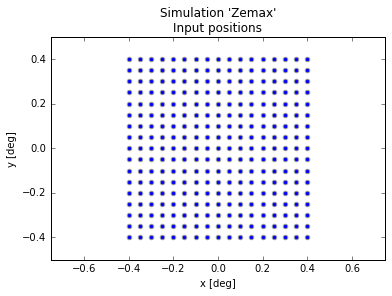

In [5]:
ax = zmx_pos.plot_input()

In [6]:
simcfg = zmx_pos.get_simcfg()     # Simulation configuration
print(simcfg)

------------------ Simulation configuration 'Zemax' ------------------
  name                : Zemax
  wave_npx            : 13
  wave_range          : [1.1999999999999999e-06, 1.7999999999999999e-06]
  modes               : [1L, 0L, 2L, 'J']
  input_coords        : [[-0.00698132 -0.00698132]
 [-0.00698132 -0.00610865]
 [-0.00698132 -0.00523599]
 ..., 
 [ 0.00698132  0.00523599]
 [ 0.00698132  0.00610865]
 [ 0.00698132  0.00698132]]


## Optical modeling

We use here the standard *collimated* model: telescope + collimator (CoLA) + [grism|filter] + camera (CaLA) + detector, even though the filter/grism is in a *f/20* beam (while the CaLA produces a *f/10* beam, hence the quoted magnification of 1/2).

In [7]:
# Optical modeling
optcfg = nisp.NISP_R  # Optical configuration (default NISP)
print(optcfg)

------------------- Optical configuration 'NISP-R' -------------------
  name                : NISP-R
  wave_ref            : 1.5e-06
  wave_range          : [1.25e-06, 1.85e-06]
  telescope_flength   : 24.5
  grism_dispersion    : 9.8
  grism_prism_material: FS
  grism_grating_material: FS
  grism_prism_angle   : 0.0363028484415
  grism_grating_rho   : 13.1
  grism_grating_blaze : 0.0453785605519
  detector_pxsize     : 1.8e-05
  collimator_flength  : 1.926
  collimator_gdist_K1 : 0.474
  collimator_gdist_y0 : 0.0232
  grism_prism_tiltx   : 0
  grism_prism_tilty   : 0
  grism_prism_tiltz   : 0
  camera_flength      : 0.9765
  camera_gdist_K1     : -0.0317
  camera_gdist_y0     : 0.201
  detector_dx         : 0.000499
  detector_dy         : 0.000634


In [8]:
spectro = S.Spectrograph(optcfg,
                         telescope=S.Telescope(optcfg))
print(spectro)

Reading 'collimator_gdist_K#i' parameters up to i=1
Reading 'camera_gdist_K#i' parameters up to i=1
---------------------------- Spectrograph ----------------------------
Telescope: f=24.5 m
  Null geometric distortion
  Null chromatic distortion
Collimator: f=1.9 m
  Geometric distortion: center=(+0, +0.0232), K-coeffs=[ 0.474], P-coeffs=[]
  Null chromatic distortion
Grism:
  Prism [FS]: A=2.08°, tilts=+0',+0',+0'
  Grating [FS]: rho=13.1 g/mm, blaze=2.60°
  1st-order null-deviation wavelength: 1.24 µm
Camera: f=1.0 m
  Geometric distortion: center=(+0, +0.201), K-coeffs=[-0.0317], P-coeffs=[]
  Null chromatic distortion
Detector: pxsize=18 µm
  Offset=(+0.499, +0.634) mm, angle=0.0 deg
Spectrograph magnification: 0.507
Central dispersion: 13.60 AA/px at 1.50 µm


In [9]:
print(" Spectrograph round-trip test ".center(70, '-'))
for mode in simcfg.get('modes', (1, 0, 2)):
    if not spectro.test(simcfg.get_wavelengths(optcfg), mode=mode, verbose=False):
        warnings.warn("Order #{}: backward modeling does not match.".format(mode))
    else:
        print("{}: OK".format(S.str_mode(mode)))

-------------------- Spectrograph round-trip test --------------------
Order #1: OK
Order #0: OK
Order #2: OK
Band J: OK


### Imagery mode

#### Distortion model

In [10]:
xy = zmx_pos['J'].mean(axis=0).values  # Mean (complex) positions (averaged over wavelengths) (289,)
grid = D.StructuredGrid(xy.reshape(17, 17))
print(grid)

Structured grid: 17 x 17 = 289 positions, y-x-


Offset: (0.001, 0.000), step: 0.011, angle: 0.0°
Center of distortion: (-0.001, -0.012)


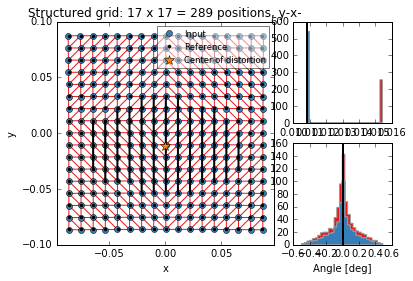

In [11]:
step, angle, offset, center = grid.estimate_parameters(fig=True)
print(u"Offset: ({0.real:.3f}, {0.imag:.3f}), step: {1:.3f}, angle: {2:.1f}°"
     .format(offset, step, N.rad2deg(angle)))
print(u"Center of distortion: ({0.real:.3f}, {0.imag:.3f})".format(center))

#### Optical model 

In [12]:
result = spectro.adjust(zmx_pos, simcfg, tol=1e-4, modes=zmx_pos.bands,
                        optparams=['detector_dy', 'detector_dx',
                                   'collimator_gdist_K1', 'camera_gdist_K1'])

====================== SPECTROGRAPH ADJUSTMENT =======================
Adjusted modes: ['J']
------------------------- Initial parameters -------------------------
  detector_dy         : 0.000634
  detector_dx         : 0.000499
  collimator_gdist_K1 : 0.474
  camera_gdist_K1     : -0.0317
Mode J RMS: 0.121303757397 mm = 6.73909763314 px
Total RMS: 0.121303757397 mm = 6.73909763314 px
Minimization succeeded: Converged (|f_n-f_(n-1)| ~= 0)
------------------------ Adjusted parameters -------------------------
  detector_dy         : 0.000637206962177
  detector_dx         : 0.000505160860991
  collimator_gdist_K1 : 0.473999986675
  camera_gdist_K1     : -0.0317002829108
  RMS: 0.121104441223 mm = 6.72802451242 px


Band J RMS = 0.1211 mm = 6.73 px


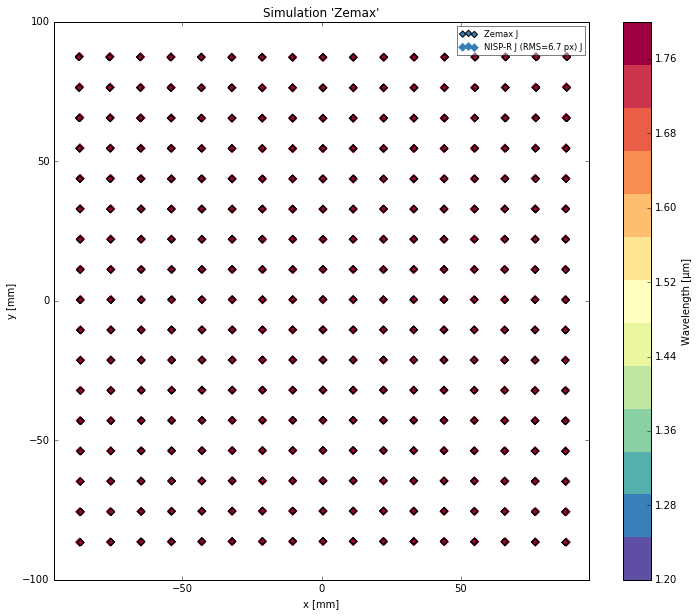

In [13]:
kwargs = dict(s=20, edgecolor='k', linewidths=1)  # Outlined symbols
ax = zmx_pos.plot_output(modes=zmx_pos.bands, **kwargs)

phot_pos = spectro.predict_positions(simcfg)

kwargs = {}                 # Default
for band in zmx_pos.bands:
    # Compute RMS on positions
    rms = zmx_pos.compute_rms(phot_pos, mode=band)
    print("Band {} RMS = {:.4f} mm = {:.2f} px".format(
        band, rms / 1e-3, rms / spectro.detector.pxsize))
    phot_pos.plot(ax=ax, zorder=0,  # Draw below Zemax
                  modes=(band,),
                  label="{} {} (RMS={:.1f} px)".format(
                      phot_pos.name, band, rms / spectro.detector.pxsize),
                  **kwargs)

ax.axis([-100, +100, -100, +100])               # [mm]
ax.set_aspect('equal', adjustable='datalim')
ax.legend(fontsize='small', frameon=True, framealpha=0.5, title='')
ax.figure.set_size_inches(12, 10)

### Spectroscopy mode

In [14]:
spe_pos = spectro.predict_positions(simcfg, orders=zmx_pos.orders)
spe_pos.check_alignment(zmx_pos)  # Would raise IndexError if incompatible

Order #1 RMS = 0.3179 mm = 17.66 px
Order #0 RMS = 0.5342 mm = 29.68 px
Order #2 RMS = 0.2504 mm = 13.91 px


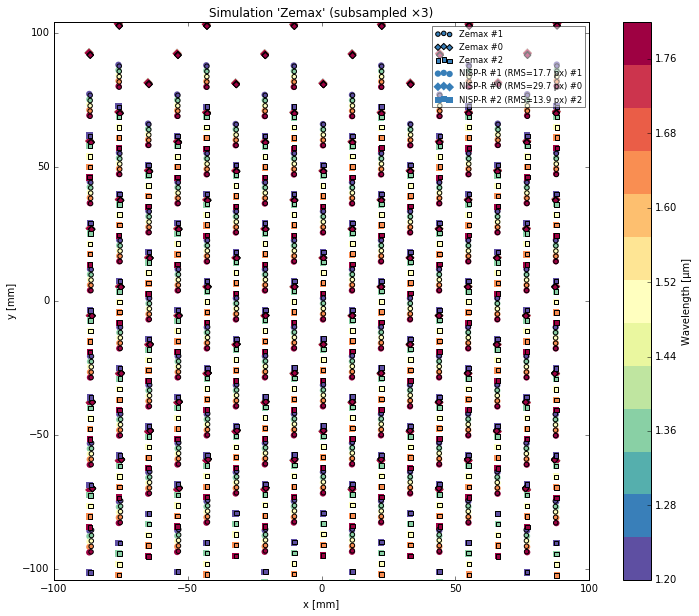

In [15]:
subsampling = 3             # Subsample output plot
kwargs = dict(s=20, edgecolor='k', linewidths=1)  # Outlined symbols
ax = zmx_pos.plot_output(modes=zmx_pos.orders, subsampling=subsampling, **kwargs)

kwargs = {}                      # Default
for order in zmx_pos.orders:
    # Compute RMS on spectra positions
    rms = zmx_pos.compute_rms(spe_pos, mode=order)
    print("Order #{} RMS = {:.4f} mm = {:.2f} px".format(order, rms / 1e-3, rms / spectro.detector.pxsize))

    spe_pos.plot(ax=ax, zorder=0,  # Draw below Zemax
                 modes=(order,),
                 subsampling=subsampling,
                 label="{} #{} (RMS={:.1f} px)".format(spe_pos.name, order, rms / spectro.detector.pxsize),
                 **kwargs)

ax.axis([-100, +100, -100, +100])               # [mm]
ax.set_aspect('equal', adjustable='datalim')
ax.legend(fontsize='small', frameon=True, framealpha=0.5, title='')
ax.figure.set_size_inches(12, 10)

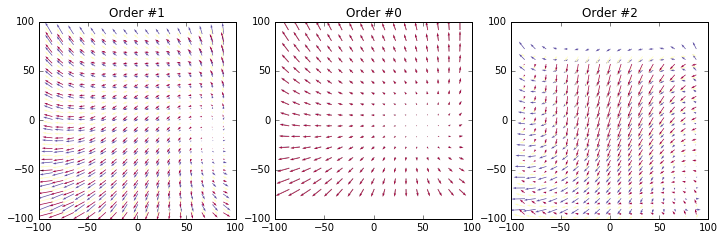

In [16]:
fig, axs = P.subplots(1, 3)
# Position offset quiver plots
for ax, order in zip(axs.ravel(), zmx_pos.orders):
    zmx_pos.plot_offsets(spe_pos, ax=ax, mode=order)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title("Order #{}".format(order))
fig.set_size_inches(12, 5)